In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from pyhessian import hessian
from tqdm import tqdm
import pandas as pd
import os

device = "cuda"

# export visible cuda to only use GPU 7
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [4]:
torch.manual_seed(0)
np.random.seed(0)

A = np.random.rand(10, 10)
print("Top 3 eivenvalues of A: ", np.linalg.eigvals(A)[0:3])

Top 3 eivenvalues of A:  [4.82560951+0.j 0.96051159+0.j 0.82240406+0.j]


In [5]:
# approximate the top eigenvalue using power iteration
v = np.random.rand(10, 1)
for i in range(100):
    v = A @ v
    v = v / np.linalg.norm(v) # numerical stability

# Rayleigh quotient
top_eigenvalue = (v.T @ A @ v) / (v.T @ v)
print("Top eigenvalue with Rayleigh quotient: ", top_eigenvalue.flatten())

Top eigenvalue with Rayleigh quotient:  [4.82560951]


In [6]:
# we can find subsequent eigenvalues by deflating the matrix
# deflating works because A = sum_i (lambda_i * v_i @ v_i^T) (under specific conditions)
A2 = A - top_eigenvalue * (v @ v.T)

v = np.random.rand(10, 1)
for i in range(200):
    v = A2 @ v
    v = v / np.linalg.norm(v) # numerical stability

# Rayleigh quotient
top_eigenvalue2 = (v.T @ A2 @ v) / (v.T @ v)
print("Top eigenvalue of A2 with Rayleigh quotient: ", top_eigenvalue2.flatten())

Top eigenvalue of A2 with Rayleigh quotient:  [0.96051159]


In [7]:
from train_mlp import muMLPTab9, SP_MLP, NTK_MLP, train, preload_subset

dl = preload_subset(512, 1)

sharp_iter = iter(dl)
sharp_x1, sharp_y1 = next(sharp_iter)
sharp_x2, sharp_y2 = next(sharp_iter)
# sharp_x3, sharp_y3 = next(sharp_iter)
# sharp_x4, sharp_y4 = next(sharp_iter)
# sharp_x, sharp_y = torch.cat([sharp_x1, sharp_x2, sharp_x3, sharp_x4]), torch.cat([sharp_y1, sharp_y2, sharp_y3, sharp_y4]).to(device)
sharp_x, sharp_y = torch.cat([sharp_x1, sharp_x2]), torch.cat([sharp_y1, sharp_y2]).to(device)

# sharp = preload_subset(512, 0.6, return_dataset=True)

In [8]:
model = SP_MLP(512).to(device)
lr = 1
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
num_epochs = 20
train_dl = dl
criterion = nn.CrossEntropyLoss()

lambdas = []
losses = []

model.train()
for epoch in tqdm(range(num_epochs)):
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_dl):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)
        loss.backward()
        optimizer.step()
    
    # compute the Hessian
    model.eval()
    hess = hessian(model, criterion=criterion, data=(sharp_x, sharp_y), cuda=True)
    lambdas.append(hess.eigenvalues()[0])
    losses.append(train_loss / len(train_dl.dataset))

train_loss / len(train_dl.dataset)

  0%|          | 0/20 [00:00<?, ?it/s]/opt/common/envs/mup-abc/lib/python3.11/site-packages/torch/autograd/graph.py:823: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /pytorch/torch/csrc/autograd/engine.cpp:1260.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


nan

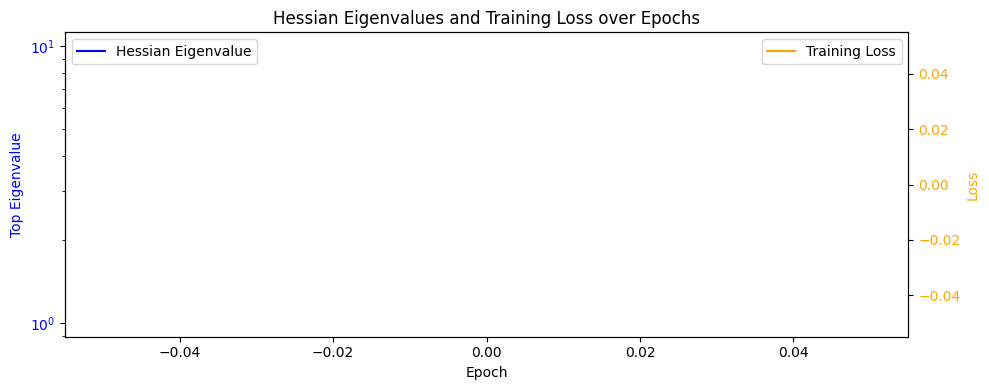

In [9]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot Hessian eigenvalues and training loss on the same plot with two y-axes
ax1.plot(range(len(lambdas)), [l[0] for l in lambdas], label="Hessian Eigenvalue", color="blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Top Eigenvalue", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_yscale("log")

ax2 = ax1.twinx()
ax2.plot(range(len(losses)), losses, label="Training Loss", color="orange")
ax2.set_ylabel("Loss", color="orange")
ax2.tick_params(axis='y', labelcolor="orange")

ax1.set_title("Hessian Eigenvalues and Training Loss over Epochs")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [10]:
def train_epoch(model, train_dl, criterion, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_dl):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item() * data.size(0)
        loss.backward()
        optimizer.step()
    return train_loss / len(train_dl.dataset)

def get_top_eigenvalue(model, criterion, data, target):
    model.eval()
    hess = hessian(model, criterion=criterion, data=(data, target), cuda=True)
    return hess.eigenvalues(maxIter=400)[0]

lambdas = pd.DataFrame()
losses = pd.DataFrame()

In [ ]:
import math
criterion = nn.CrossEntropyLoss()

num_epochs = 40
widths = [128, 256, 512, 1024, 2048]
lrs = [0.01, 0.1, 0.9][::-1]

print(f"lrs: {lrs}")

lambdas_dict = {}
losses_dict = {}
for lr in lrs:
    for width in widths:
        print(f"Width: {width}")
        model = muMLPTab9(width).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
        train_dl = dl

        lambdas = []
        losses = []

        
        for epoch in range(num_epochs):
            top_eigenvalue = get_top_eigenvalue(model, criterion, sharp_x, sharp_y)
            lambdas.append(top_eigenvalue[0])

            train_loss = train_epoch(model, train_dl, criterion, optimizer, device)
            losses.append(train_loss / len(train_dl.dataset))

            if math.isnan(train_loss) or math.isnan(lambdas[-1]):
                print(f"NaN detected at epoch {epoch} for lr {lr} and width {width}")
                break

        print(f"{lr=}, {width=}, {losses[-1]=}, {lambdas[-1]=}")
        lambdas_dict[("mup", lr, width)] = lambdas
        losses_dict[("mup", lr, width)] = losses

df_lambdas = pd.DataFrame(lambdas_dict)
df_losses = pd.DataFrame(losses_dict)

lrs: [0.9, 0.1, 0.01]
Width: 128


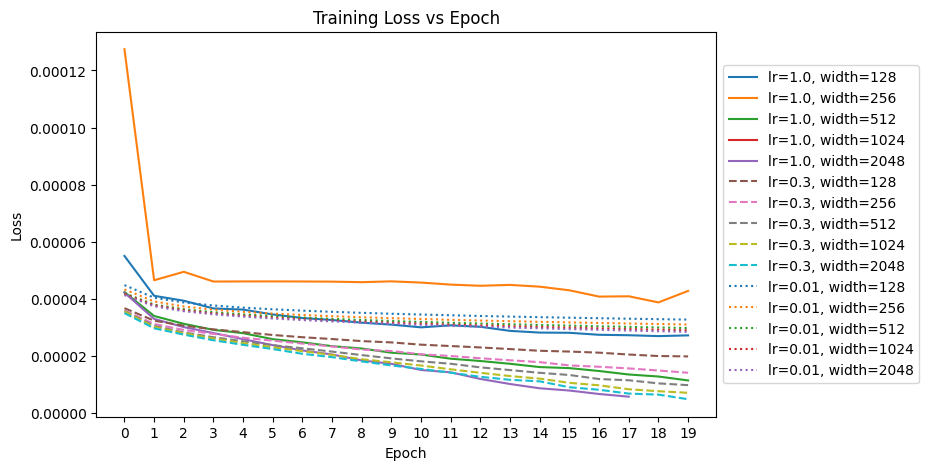

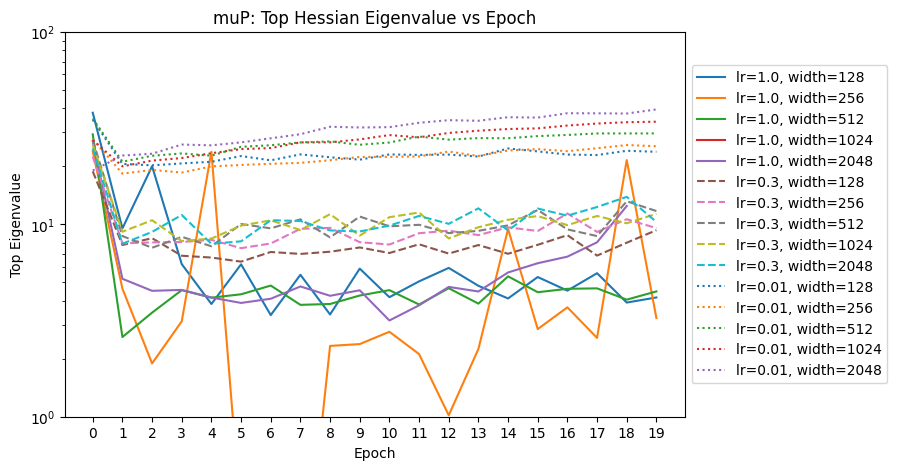

In [22]:
linestyles = {lr: ls for lr, ls in zip(lrs, ['-', '--', ':'])}

# Plot training loss with different linestyles for the second column of the multiindex
fig, ax = plt.subplots(figsize=(8, 5))
for col in df_losses.columns:
    linestyle = linestyles[col[1]]
    ax.plot(df_losses.index, df_losses[col], label=f"lr={col[1]}, width={col[2]}", linestyle=linestyle)
ax.set_title("Training Loss vs Epoch")
plt.xticks(df_losses.index)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plot top Hessian eigenvalue with different linestyles for the second column of the multiindex
fig, ax = plt.subplots(figsize=(8, 5))
for col in df_lambdas.columns:
    linestyle = linestyles[col[1]]
    ax.plot(df_lambdas.index, df_lambdas[col], label=f"lr={col[1]}, width={col[2]}", linestyle=linestyle)
ax.set_title("muP: Top Hessian Eigenvalue vs Epoch")
plt.xticks(df_lambdas.index)
ax.set_xlabel("Epoch")
ax.set_ylabel("Top Eigenvalue")
ax.set_yscale("log")
ax.set_ylim(1e-0, 1e2)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()

num_epochs = 40
widths = [64, 128, 256, 512, 1024, 2048]
# widths = [64]
# lrs = np.linspace(-9, -7, 3)
lrs = [1, 5, 10]
train_dl = dl

print(f"lrs: {lrs}")

lambdas_dict = {}
losses_dict = {}
for lr in lrs:
    # lr = 2**lr2
    for width in widths:
        print(f"Width: {width}")
        model = NTK_MLP(width).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
        train_dl = dl

        lambdas = []
        losses = []

        
        for epoch in range(num_epochs):
            top_eigenvalue = get_top_eigenvalue(model, criterion, sharp_x, sharp_y)
            lambdas.append(top_eigenvalue[0])

            train_loss = train_epoch(model, train_dl, criterion, optimizer, device)
            losses.append(train_loss / len(train_dl.dataset))

        print(f"{lr=}, {width=}, {losses[-1]=}, {lambdas[-1]=}")
        lambdas_dict[("ntk", lr, width)] = lambdas
        losses_dict[("ntk", lr, width)] = losses

lambdas_df2 = pd.DataFrame(lambdas_dict)
losses_df2 = pd.DataFrame(losses_dict)

lrs: [1, 5, 10]
Width: 64
lr=1, width=64, losses[-1]=3.367586841430664e-05, lambdas[-1]=1.2523174285888672
Width: 128
lr=1, width=128, losses[-1]=3.200376720809936e-05, lambdas[-1]=1.2800601720809937
Width: 256
lr=1, width=256, losses[-1]=3.0067031660461425e-05, lambdas[-1]=1.1043250560760498
Width: 512
lr=1, width=512, losses[-1]=2.7473605940246583e-05, lambdas[-1]=1.3371249437332153
Width: 1024
lr=1, width=1024, losses[-1]=2.4917180646514893e-05, lambdas[-1]=1.866978406906128
Width: 2048
lr=1, width=2048, losses[-1]=2.3253600019836424e-05, lambdas[-1]=2.071605682373047
Width: 64
lr=5, width=64, losses[-1]=3.158893569869995e-05, lambdas[-1]=0.42354267835617065
Width: 128
lr=5, width=128, losses[-1]=2.7935698602294922e-05, lambdas[-1]=0.33420529961586
Width: 256
lr=5, width=256, losses[-1]=2.4258721492004396e-05, lambdas[-1]=0.23328807950019836
Width: 512
lr=5, width=512, losses[-1]=1.8920698627471922e-05, lambdas[-1]=0.16794532537460327
Width: 1024
lr=5, width=1024, losses[-1]=1.34370

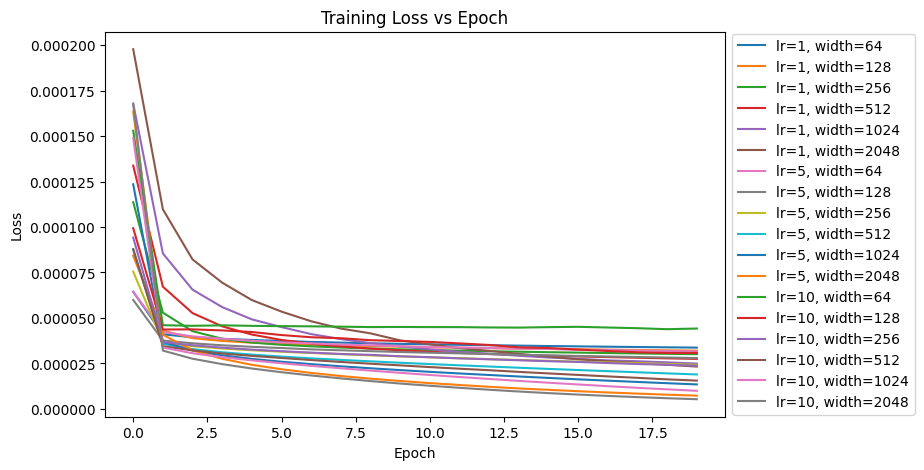

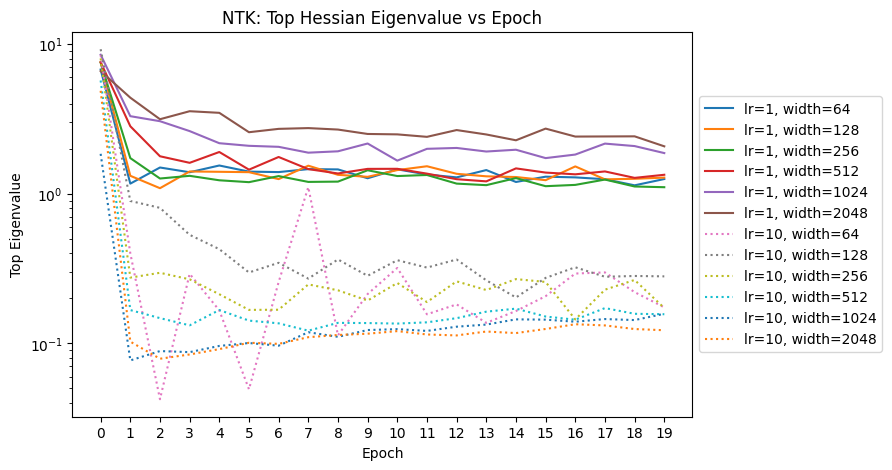

In [24]:
linestyles = {lr: ls for lr, ls in zip(lrs, ['-', '--', ':'])}

# Plot training loss with different linestyles for the second column of the multiindex
fig, ax = plt.subplots(figsize=(8, 5))
for col in losses_df2.columns:
    # linestyle = linestyles[col[1]]
    linestyle = '-'
    ax.plot(losses_df2.index, losses_df2[col], label=f"lr={col[1]}, width={col[2]}", linestyle=linestyle)
ax.set_title("Training Loss vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plot top Hessian eigenvalue with different linestyles for the second column of the multiindex
fig, ax = plt.subplots(figsize=(8, 5))
for col in lambdas_df2.columns:
    linestyle = linestyles[col[1]]
    if col[1] == 5:
        continue
    ax.plot(lambdas_df2.index, lambdas_df2[col], label=f"lr={col[1]}, width={col[2]}", linestyle=linestyle)
ax.set_title("NTK: Top Hessian Eigenvalue vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Top Eigenvalue")
ax.set_yscale("log")
plt.xticks(lambdas_df2.index)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()